In [1]:
% matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas
import torch, torch.utils.data, torchvision
import PIL
import os.path
import time
import skimage, skimage.io
import time
import copy
from my_utils import *

In [2]:
MEAN = [0.485, 0.456, 0.406] # expected by pretrained resnet18
STD = [0.229, 0.224, 0.225] # expected by pretrained resnet18

# Full model

In [3]:
# load the data and add a column for occurrences
df = pandas.read_csv('./data/train.csv')
grouped = df.groupby('Id')
df['occurrences'] =  grouped.Id.transform('count')

In [4]:
# define transformations with data augmentation.
# These are the same transformations that were used for the toy_model
transforms_augm = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=20.0), # Data augmentation
    torchvision.transforms.RandomGrayscale(), # Data augmentation
    # torchvision.transforms.Resize((224,int(224.0*16.0/9.0))),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(), # Expected by pretrained neural network
    torchvision.transforms.Normalize(MEAN, STD) # Expected by pretrained neural network
    ])

In [5]:
# Load the full dataset. Using a random subset as the validation set is difficult because
# many of the categories appear only a single time. I could try to use cross-validation instead,
# but for the moment I am just going to ignore the validation set.
full_data = WhaleDataset(df,'./data/',transform=transforms_augm)
full_dataloader = {'train': torch.utils.data.DataLoader(full_data,\
                                                   batch_size=4,\
                                                   num_workers=4,\
                                                   shuffle=True,\
                                                   sampler=None)}

In [6]:
# load the toy_model
toy_model = torch.load('./toy_model_all_layers_trained.pt')
print toy_model.fc

Linear(in_features=512, out_features=56, bias=True)


In [7]:
# Create the full model from the toy nodel by replacing the last layer
full_model = copy.deepcopy(toy_model)

# freeze layers
for params in full_model.parameters():
    params.requires_grad == False

# Create new final layer (unfrozen by default)
num_in = full_model.fc.in_features
num_out = len(full_dataloader['train'].dataset.categories)
full_model.fc = torch.nn.Linear(num_in,num_out)


# define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
full_model.to(device)

print full_model.fc

Linear(in_features=512, out_features=4251, bias=True)


In [8]:
# Choose the loss function (criterion) and optimizer.
# I make the same choice as for the toy_model.
criterion = torch.nn.CrossEntropyLoss()
full_optimizer = torch.optim.Adam(full_model.fc.parameters(),lr=0.001)

In [9]:
# train the full model
full_model, loss_vals, acc_vals = train_with_restart(
    full_model,full_dataloader,criterion,full_optimizer,device,\
    use_val=False,num_epochs=30)

Epoch 0 / 30
Training: Elapsed time: 3174.1572 Loss: 9.6565 Acc: 0.0836
Epoch 1 / 30
Training: Elapsed time: 6329.4689 Loss: 5.8781 Acc: 0.0925
Epoch 2 / 30
Training: Elapsed time: 9489.7782 Loss: 5.0812 Acc: 0.1217
Epoch 3 / 30
Training: Elapsed time: 12652.6803 Loss: 4.4482 Acc: 0.1659
Epoch 4 / 30
Training: Elapsed time: 15814.9887 Loss: 3.8642 Acc: 0.2216
Epoch 5 / 30
Training: Elapsed time: 18964.6980 Loss: 3.3309 Acc: 0.2917
Epoch 6 / 30
Training: Elapsed time: 22129.9876 Loss: 2.8245 Acc: 0.3695
Epoch 7 / 30
Training: Elapsed time: 25306.8060 Loss: 2.4689 Acc: 0.4515
Epoch 8 / 30
Training: Elapsed time: 28516.4583 Loss: 2.1332 Acc: 0.5112
Epoch 9 / 30
Training: Elapsed time: 31795.9411 Loss: 1.8834 Acc: 0.5743
Epoch 10 / 30
Training: Elapsed time: 35083.2242 Loss: 1.7264 Acc: 0.6052
Epoch 11 / 30
Training: Elapsed time: 38348.0572 Loss: 3.8454 Acc: 0.2318
Epoch 12 / 30
Training: Elapsed time: 41530.2257 Loss: 3.4977 Acc: 0.2911
Epoch 13 / 30
Training: Elapsed time: 44710.9796 Lo

In [10]:
torch.save(full_model,'full_model.pt')

<IPython.core.display.Javascript object>


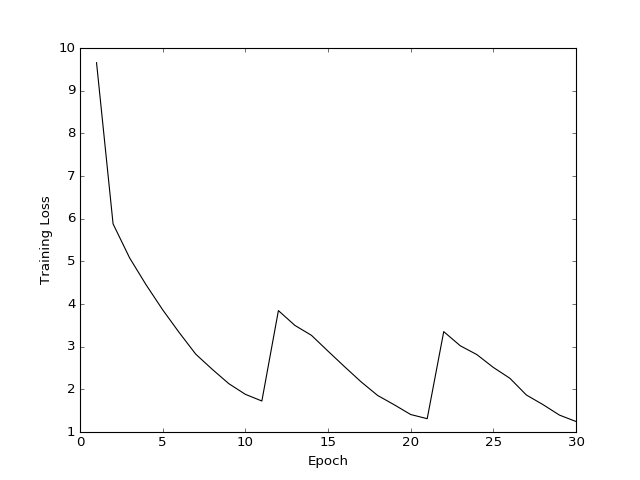

In [12]:
plt.figure()
plt.plot(range(1,31),loss_vals['train'],'-k')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

Maybe I should increase the periodicity of the restarts a bit.